In [26]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
from rich.progress import track

sns.set(color_codes=True, style="white")

### Load Data

In [ ]:
folder_save = "/Users/esumrall/Desktop/local-data/RDF/"
os.chdir(folder_save)

label1 = "0 h"
label2 = "8 h"
label3 = "24 h"
color1 = "#f7a863"
color2 = "#d25743"
color3 = "#2B3744"
palette = [color1, color2, color3]

postfix = "FUS-aging3steps.png"
fname1 = "distance2center-FUSonly_nothing-pooled-perTrack.p"
fname2_1 = "distance2center-FUSonly_8h_before_ring_complete-pooled-perTrack.p"
fname2_2 = "distance2center-FUSonly_24h_before_ring_complete-pooled-perTrack.p"
fname3_1 = "distance2center-FUSonly_8h_ring_completed-pooled-perTrack.p"
fname3_2 = "distance2center-FUSonly_24h_ring_completed-pooled-perTrack.p"

r_max = 1
ringwidth = 0.2
dr_slidingrings = 0.05
bin_starts = np.arange(0, r_max - ringwidth, dr_slidingrings)
bin_ends = bin_starts + ringwidth
ring_areas = np.pi * (bin_ends**2 - bin_starts**2)

def combine_dicts(dicts):
    """Combine several dictionaries with the same set of keys into one dictionary where each value is a list of all values for that key, keeping only specified keys."""
    combined = {}
    for d in dicts:
        for key, value in d.items():
            if key in combined:
                combined[key].extend(value)
            else:
                combined[key] = value.copy()
    return combined

dict1 = pickle.load(open(fname1, "rb"))
dict2 = pickle.load(open(fname2_1, "rb"))
dict2_1 = pickle.load(open(fname2_1, "rb"))
dict2_2 = pickle.load(open(fname2_2, "rb"))
dict3 = pickle.load(open(fname3_1, "rb"))
dict3_1 = pickle.load(open(fname3_1, "rb"))
dict3_2 = pickle.load(open(fname3_2, "rb"))

dict2 = combine_dicts([dict2_1, dict2_2])
dict3 = combine_dicts([dict3_1, dict3_2])

### Functions

In [28]:
def weighted_stats(lst_PCF_per_condensate_raw, lst_N_locations_raw):
    # cleaning out nan from list
    lst_N_locations = []
    lst_PCF_per_condensate = []
    for i, j in zip (lst_N_locations_raw, lst_PCF_per_condensate_raw):
        if np.isnan(j).any():
            continue
        else:
            lst_N_locations.append(i)
            lst_PCF_per_condensate.append(j)

    # create arrays for weighted means, SEMs and STDs
    N_condensates = len(lst_N_locations)
    N_bins = lst_PCF_per_condensate[0].shape[0]
    weighted_mean = np.zeros(N_bins)
    weighted_sem = np.zeros(N_bins)
    weighted_std = np.zeros(N_bins)
    weights = np.array(lst_N_locations)

    # iterate over the length of a numpy array in the list
    for i in range(N_bins):
        # extract the i-th element from each array and their respective weight
        data_array = np.array(
            [lst_PCF_per_condensate[j][i] for j in range(N_condensates)]
        )
        # calculate the weighted mean
        weighted_mean[i] = np.average(data_array, weights=weights)
        # calculate the variance
        variance = np.average((data_array - weighted_mean[i]) ** 2, weights=weights)
        # calculate the weighted SEM
        weighted_sem[i] = np.sqrt(variance / N_condensates)
        # calculate the weighted STD
        weighted_std[i] = np.sqrt(variance)

    return weighted_mean, weighted_sem, weighted_std


def critical_system_PCF(r, A, characteristic_size):
    Gr = 1 + A * np.exp(-r / characteristic_size)
    return Gr


def calculate_hist(d2center_norm, r_max, bin_starts, bin_ends, ring_areas):
    # calculate histogram
    lst_hist = []
    for distance in d2center_norm[d2center_norm <= r_max]:
        lst_hist.append(((bin_starts <= distance) & (bin_ends >= distance)) * 1)
    hist = np.sum(lst_hist, axis=0)

    # determine normalization factors
    N_domains = d2center_norm[d2center_norm <= r_max].shape[0]
    rho_per_unit_circle = N_domains / (np.pi * 1**2)
    norm_factors = ring_areas * rho_per_unit_circle
    distribution = hist / norm_factors
    probability_norm = distribution / distribution.sum()

    return probability_norm


def bootstrap(d2center_norm, bs_size, bs_rounds):
    lst_probability_norm = []
    for i in track(range(bs_rounds)):
        idxs = np.random.choice(len(d2center_norm), bs_size)
        d2center_norm_bs = np.array([d2center_norm[idx] for idx in idxs], float)
        probability_norm = calculate_hist(
            d2center_norm_bs, r_max, bin_starts, bin_ends, ring_areas
        )

        lst_probability_norm.append(probability_norm)

    probability_norm_array = np.stack(lst_probability_norm)

    return probability_norm_array


def preprocessing(dict_input):
    lst_df_d2center = dict_input["lst_df_d2center"]
    lst_d2center_norm = [df["d2center_norm"].to_numpy(float) for df in lst_df_d2center]
    d2center_norm = np.hstack(lst_d2center_norm)
    probability_norm_array = bootstrap(d2center_norm, bs_size=5000, bs_rounds=1000)

    return probability_norm_array

### Domain distribution in condensate

In [29]:
probability_norm_array_1 = preprocessing(dict1)
probability_norm_array_2 = preprocessing(dict2)
probability_norm_array_3 = preprocessing(dict3)

Output()

Output()

Output()

In [30]:
def mean_err_for_plot(probability_norm_array):
    lst_mean = []
    lst_err = []
    for i in range(probability_norm_array.shape[1]):
        column = probability_norm_array[:, i]
        ci = (np.percentile(column, 5), np.percentile(column, 95))
        bs_mean = np.mean(ci)
        bs_err = (ci[1] - ci[0]) / 2
        lst_mean.append(bs_mean)
        lst_err.append(bs_err)

    return lst_mean, lst_err

lst_mean_1, lst_err_1 = mean_err_for_plot(probability_norm_array_1)
lst_mean_2, lst_err_2 = mean_err_for_plot(probability_norm_array_2)
lst_mean_3, lst_err_3 = mean_err_for_plot(probability_norm_array_3)


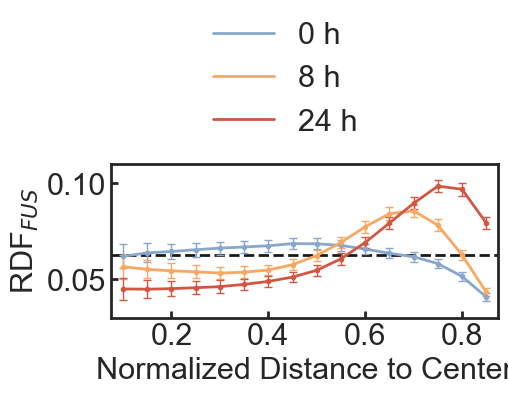

In [31]:
fontsize = 22


def preset_plot(lst_mean, lst_err, c, label):
    plt.errorbar(
        bar_x,
        lst_mean,
        yerr=lst_err,
        fmt=".",
        color=c,
        ecolor=c,
        elinewidth=1,
        capsize=3,
        label=None,
    )
    (line,) = plt.plot(
        bar_x,
        lst_mean,
        color=c,
        lw=2,
        label=label,
    )
    return line


plt.figure(figsize=(5, 2))
plt.axhline(1 / len(bin_starts), c="k", ls="--", lw=2)
bar_x = (bin_starts + bin_ends) / 2

# Collect line objects for legend
lines = []
lines.append(preset_plot(lst_mean_1, lst_err_1, color1, label1))
lines.append(preset_plot(lst_mean_2, lst_err_2, color2, label2))
lines.append(preset_plot(lst_mean_3, lst_err_3, color3, label3))

# Configure legend using only line objects
plt.legend(
    handles=lines,
    loc="lower center",
    bbox_to_anchor=(0.45, 1),
    ncol=1,
    title=None,
    frameon=False,
    fontsize=fontsize,
)

plt.xlim(bar_x[0] - dr_slidingrings / 2, bar_x[-1] + dr_slidingrings / 2)
# plt.xlim(0, 1)
plt.ylim(0.03, 0.11)
plt.ylabel("RDF$_{FUS}$", fontsize=fontsize)
plt.xlabel("Normalized Distance to Center", fontsize=fontsize)
# plt.ylabel("")
plt.gca().spines[:].set_linewidth(2)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=fontsize,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=2,
)
plt.savefig(
    "d2center_distribution" + postfix,
    format="png",
    bbox_inches="tight",
    dpi=300,
)
# baseline = 1 / len(bin_starts)
# print(
#     lst_mean[0] / baseline,
#     lst_err[0] / baseline,
#     bar_x[-5],
#     lst_mean[-5] / baseline,
#     lst_err[-5] / baseline,
# )

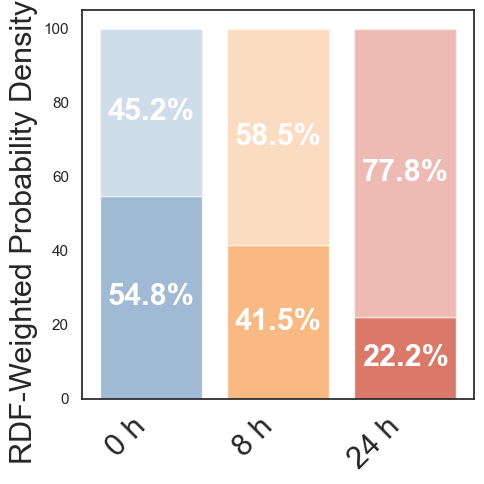

Distance threshold: 0.6

0 h:
  ≤ 0.6: 54.8%
  > 0.6: 45.2%

8 h:
  ≤ 0.6: 41.5%
  > 0.6: 58.5%

24 h:
  ≤ 0.6: 22.2%
  > 0.6: 77.8%


In [32]:
### Weighted Bar Plot: Frequency × RDF Values
threshold = 0.6


def calculate_weighted_freq_distribution_with_rdf(dict_input, probability_norm_array, threshold):
    lst_df_d2center = dict_input["lst_df_d2center"]
    lst_d2center_norm = [df["d2center_norm"].to_numpy(float) for df in lst_df_d2center]
    d2center_norm = np.hstack(lst_d2center_norm)
    
    # Filter distances within r_max
    d2center_norm = d2center_norm[d2center_norm <= r_max]
    
    # Calculate RDF values for each distance using the mean RDF across bootstrap samples
    mean_rdf = np.mean(probability_norm_array, axis=0)
    
    weighted_below = 0
    weighted_above = 0
    
    for distance in d2center_norm:
        # Find which bin this distance falls into
        bin_idx = np.searchsorted(bin_starts, distance) - 1
        bin_idx = np.clip(bin_idx, 0, len(mean_rdf)-1)
        
        # Get the corresponding RDF value
        rdf_value = mean_rdf[bin_idx] if bin_idx < len(mean_rdf) else 0
        
        if distance <= threshold:
            weighted_below += rdf_value
        else:
            weighted_above += rdf_value
    
    total_weight = weighted_below + weighted_above
    if total_weight > 0:
        weighted_below_pct = weighted_below / total_weight * 100
        weighted_above_pct = weighted_above / total_weight * 100
    else:
        weighted_below_pct = weighted_above_pct = 0
        
    return weighted_below_pct, weighted_above_pct

# Set threshold
threshold = 0.6

# Calculate weighted frequencies for each condition using their respective RDF data
weighted_below_1, weighted_above_1 = calculate_weighted_freq_distribution_with_rdf(dict1, probability_norm_array_1, threshold)
weighted_below_2, weighted_above_2 = calculate_weighted_freq_distribution_with_rdf(dict2, probability_norm_array_2, threshold)  
weighted_below_3, weighted_above_3 = calculate_weighted_freq_distribution_with_rdf(dict3, probability_norm_array_3, threshold)

# Create weighted stacked bar plot
fig, ax = plt.subplots(figsize=(5, 5))

conditions = [label1, label2, label3]
weighted_below_freqs = [weighted_below_1, weighted_below_2, weighted_below_3]
weighted_above_freqs = [weighted_above_1, weighted_above_2, weighted_above_3]
colors = [color1, color2, color3]

bar_width = 0.8
x_pos = np.arange(len(conditions))

# Bottom bars (≤ 0.6) - weighted by RDF
bars1 = ax.bar(x_pos, weighted_below_freqs, bar_width, 
               label=f'RDF-weighted density ≤ {threshold}', 
               color=colors, alpha=0.8)

# Top bars (> 0.6) - weighted by RDF  
bars2 = ax.bar(x_pos, weighted_above_freqs, bar_width, 
               bottom=weighted_below_freqs,
               label=f'RDF-weighted density > {threshold}', 
               color=colors, alpha=0.4)

# Customize the plot
fontsize = 22
# ax.set_xlabel('Condition')
ax.set_ylabel('RDF-Weighted Probability Density (%)', fontsize=fontsize)
# ax.set_title(f'RDF-Weighted Distribution by Distance to Center\n(Threshold = {threshold})')
ax.set_xticks(x_pos)
ax.set_xticklabels(conditions, rotation=45, ha='right', fontsize=fontsize)

# Add percentage labels on bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Label for bottom segment
    height1 = bar1.get_height()
    if height1 > 5:  # Only show label if segment is large enough
        ax.text(bar1.get_x() + bar1.get_width()/2., height1/2,
                f'{height1:.1f}%', ha='center', va='center', fontweight='bold', color='white', fontsize=fontsize)
    
    # Label for top segment  
    height2 = bar2.get_height()
    if height2 > 5:  # Only show label if segment is large enough
        ax.text(bar2.get_x() + bar2.get_width()/2., height1 + height2/2,
                f'{height2:.1f}%', ha='center', va='center', fontweight='bold', color='white', fontsize=fontsize)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Distance threshold: {threshold}")
print(f"\n{label1}:")
print(f"  ≤ {threshold}: {weighted_below_1:.1f}%")
print(f"  > {threshold}: {weighted_above_1:.1f}%")
print(f"\n{label2}:")
print(f"  ≤ {threshold}: {weighted_below_2:.1f}%") 
print(f"  > {threshold}: {weighted_above_2:.1f}%")
print(f"\n{label3}:")
print(f"  ≤ {threshold}: {weighted_below_3:.1f}%")
print(f"  > {threshold}: {weighted_above_3:.1f}%")


In [33]:
### Bootstrap Calculations - Run This Cell Once

def calculate_weighted_freq_distribution_with_bootstrap_error(dict_input, probability_norm_array, threshold, condition_name):
    lst_df_d2center = dict_input["lst_df_d2center"]
    lst_d2center_norm = [df["d2center_norm"].to_numpy(float) for df in lst_df_d2center]
    d2center_norm = np.hstack(lst_d2center_norm)
    
    # Filter distances within r_max
    d2center_norm = d2center_norm[d2center_norm <= r_max]
    
    # Calculate weighted percentages for each bootstrap sample
    n_bootstrap = probability_norm_array.shape[0]
    weighted_below_bootstrap = []
    weighted_above_bootstrap = []
    
    print(f"Processing {condition_name}: {n_bootstrap} bootstrap samples...")
    
    for boot_idx in range(n_bootstrap):
        # Print progress every 100 iterations
        if (boot_idx + 1) % 100 == 0:
            print(f"  {condition_name}: Completed {boot_idx + 1}/{n_bootstrap} bootstrap samples ({((boot_idx + 1)/n_bootstrap)*100:.1f}%)")
        
        rdf_values = probability_norm_array[boot_idx, :]
        
        weighted_below = 0
        weighted_above = 0
        
        for distance in d2center_norm:
            # Find which bin this distance falls into
            bin_idx = np.searchsorted(bin_starts, distance) - 1
            bin_idx = np.clip(bin_idx, 0, len(rdf_values)-1)
            
            # Get the corresponding RDF value
            rdf_value = rdf_values[bin_idx] if bin_idx < len(rdf_values) else 0
            
            if distance <= threshold:
                weighted_below += rdf_value
            else:
                weighted_above += rdf_value
        
        total_weight = weighted_below + weighted_above
        if total_weight > 0:
            weighted_below_pct = weighted_below / total_weight * 100
            weighted_above_pct = weighted_above / total_weight * 100
        else:
            weighted_below_pct = weighted_above_pct = 0
            
        weighted_below_bootstrap.append(weighted_below_pct)
        weighted_above_bootstrap.append(weighted_above_pct)
    
    print(f"  ✓ {condition_name}: Bootstrap completed!")
    
    # Calculate mean and confidence intervals
    below_mean = np.mean(weighted_below_bootstrap)
    above_mean = np.mean(weighted_above_bootstrap)
    
    # Calculate 90% confidence intervals (5th and 95th percentiles)
    below_ci = np.percentile(weighted_below_bootstrap, [5, 95])
    above_ci = np.percentile(weighted_above_bootstrap, [5, 95])
    
    # Calculate error bar values (distance from mean to CI bounds)
    below_err = [below_mean - below_ci[0], below_ci[1] - below_mean]
    above_err = [above_mean - above_ci[0], above_ci[1] - above_mean]
        
    return below_mean, above_mean, below_err, above_err

# Set threshold
threshold = 0.6

print("=" * 60)
print("STARTING RDF-WEIGHTED BOOTSTRAP ANALYSIS")
print("=" * 60)

# Calculate weighted frequencies with error bars for each condition
print(f"\n[1/3] Starting analysis for condition: {label1}")
below_1, above_1, below_err_1, above_err_1 = calculate_weighted_freq_distribution_with_bootstrap_error(
    dict1, probability_norm_array_1, threshold, label1)

print(f"\n[2/3] Starting analysis for condition: {label2}")
below_2, above_2, below_err_2, above_err_2 = calculate_weighted_freq_distribution_with_bootstrap_error(
    dict2, probability_norm_array_2, threshold, label2)

print(f"\n[3/3] Starting analysis for condition: {label3}")
below_3, above_3, below_err_3, above_err_3 = calculate_weighted_freq_distribution_with_bootstrap_error(
    dict3, probability_norm_array_3, threshold, label3)

print("\n" + "=" * 60)
print("ALL BOOTSTRAP CALCULATIONS COMPLETED!")
print("=" * 60)
print("Bootstrap results stored in variables. You can now run the plotting cell multiple times.")


STARTING RDF-WEIGHTED BOOTSTRAP ANALYSIS

[1/3] Starting analysis for condition: 0 h
Processing 0 h: 1000 bootstrap samples...
  0 h: Completed 100/1000 bootstrap samples (10.0%)
  0 h: Completed 200/1000 bootstrap samples (20.0%)
  0 h: Completed 300/1000 bootstrap samples (30.0%)
  0 h: Completed 400/1000 bootstrap samples (40.0%)
  0 h: Completed 500/1000 bootstrap samples (50.0%)
  0 h: Completed 600/1000 bootstrap samples (60.0%)
  0 h: Completed 700/1000 bootstrap samples (70.0%)
  0 h: Completed 800/1000 bootstrap samples (80.0%)
  0 h: Completed 900/1000 bootstrap samples (90.0%)
  0 h: Completed 1000/1000 bootstrap samples (100.0%)
  ✓ 0 h: Bootstrap completed!

[2/3] Starting analysis for condition: 8 h
Processing 8 h: 1000 bootstrap samples...
  8 h: Completed 100/1000 bootstrap samples (10.0%)
  8 h: Completed 200/1000 bootstrap samples (20.0%)
  8 h: Completed 300/1000 bootstrap samples (30.0%)
  8 h: Completed 400/1000 bootstrap samples (40.0%)
  8 h: Completed 500/1000 b

Generating plot with current aesthetic settings...


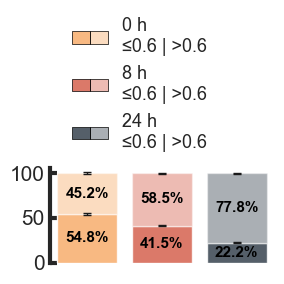

Plot generation completed!

FINAL RESULTS:
Distance threshold: 0.6

0 h:
  ≤ 0.6: 54.8% ± 1.1%
  > 0.6: 45.2% ± 1.1%

8 h:
  ≤ 0.6: 41.5% ± 1.0%
  > 0.6: 58.5% ± 1.0%

24 h:
  ≤ 0.6: 22.2% ± 0.8%
  > 0.6: 77.8% ± 0.8%


In [40]:
### Plotting Code - Run This Cell to Generate/Modify Plot

from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches

# Custom classes for multi-color legend entries
class MulticolorPatch(object):
    def __init__(self, colors, labels):
        self.colors = colors
        self.labels = labels

class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []

        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent,
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height,
                           facecolor=c,
                           edgecolor='black',
                           linewidth=0.5))

        patch = PatchCollection(patches, match_original=True)
        handlebox.add_artist(patch)
        return patch

# Aesthetic parameters (modify these as needed)
fontsize = 15
figsize = (3, 3)
bar_width = 0.8
alpha_bottom = 0.8
alpha_top = 0.4
capsize = 3
error_linewidth = 1
rotation_angle = 45

color1 = "#f7a863"
color2 = "#d25743"
color3 = "#2B3744"

print("Generating plot with current aesthetic settings...")

# Create weighted stacked bar plot with error bars
fig, ax = plt.subplots(figsize=figsize)

conditions = [label1, label2, label3]
weighted_below_freqs = [below_1, below_2, below_3]
weighted_above_freqs = [above_1, above_2, above_3]
colors = [color1, color2, color3]

# Prepare error bar data
below_errors = np.array([below_err_1, below_err_2, below_err_3]).T
above_errors = np.array([above_err_1, above_err_2, above_err_3]).T

x_pos = np.arange(len(conditions))

# Bottom bars (≤ 0.6) - weighted by RDF with error bars
bars1 = ax.bar(x_pos, weighted_below_freqs, bar_width, 
               yerr=below_errors,
               label=f'RDF-weighted density ≤ {threshold}', 
               color=colors, alpha=alpha_bottom,
               capsize=capsize, error_kw={'linewidth': error_linewidth, 'capthick': error_linewidth})

# Top bars (> 0.6) - weighted by RDF with error bars
bars2 = ax.bar(x_pos, weighted_above_freqs, bar_width, 
               bottom=weighted_below_freqs,
               yerr=above_errors,
               label=f'RDF-weighted density > {threshold}', 
               color=colors, alpha=alpha_top,
               capsize=capsize, error_kw={'linewidth': error_linewidth, 'capthick': error_linewidth})

# Customize the plot
ax.set_xlabel('', fontsize=fontsize)  # Empty xlabel like reference
# ax.set_ylabel('RDF-Weighted Probability Density (%)', fontsize=fontsize)
# ax.set_title(f'RDF-Weighted Distribution by Distance to Center\n(Threshold = {threshold})', fontsize=fontsize)
ax.set_xticks([])

# Set y-tick
ax.set_yticks([0, 50, 100])

ax.tick_params(axis='y',
               labelsize=fontsize,
               direction='in',
               bottom=True,
               left=True,
               length=5,
               width=3)

# Spine styling like reference
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)  # Hide bottom spine
for spine in ax.spines.values():
    spine.set_linewidth(3)  # Make remaining spines thicker

# Custom x-limits
canvas_width = 0.5
ax.set_xlim(-canvas_width, len(conditions)-1 + canvas_width)


# Create custom legend with split colors
legend_handles = []
legend_labels = []

for i, (condition, color) in enumerate(zip(conditions, colors)):
    # Create colors for the split legend entry
    # Darker color (higher alpha) for ≤ threshold, lighter color (lower alpha) for > threshold
    dark_color = plt.matplotlib.colors.to_rgba(color, alpha_bottom)
    light_color = plt.matplotlib.colors.to_rgba(color, alpha_top)

    # Create multicolor patch
    multicolor_patch = MulticolorPatch([dark_color, light_color], [f'≤{threshold}', f'>{threshold}'])
    legend_handles.append(multicolor_patch)
    legend_labels.append(f'{condition}\n≤{threshold} | >{threshold}')

# Add the custom legend
ax.legend(legend_handles, legend_labels,
          handler_map={MulticolorPatch: MulticolorPatchHandler()},
          frameon=False,
          fontsize=fontsize-2,
          loc='lower center',
          bbox_to_anchor=(0.4, 1),
          ncol=1)

# Add percentage labels on bars (only if segment is large enough)
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Label for bottom segment
    height1 = bar1.get_height()
    if height1 > 5:  # Only show label if segment is large enough
        ax.text(bar1.get_x() + bar1.get_width()/2., height1/2,
                f'{height1:.1f}%', ha='center', va='center', 
                fontweight='bold', color='black', fontsize=fontsize-4)

    # Label for top segment  
    height2 = bar2.get_height()
    if height2 > 5:  # Only show label if segment is large enough
        ax.text(bar2.get_x() + bar2.get_width()/2., height1 + height2/2,
                f'{height2:.1f}%', ha='center', va='center', 
                fontweight='bold', color='black', fontsize=fontsize-4)

plt.tight_layout()
plt.show()

print("Plot generation completed!")

# Print summary statistics with confidence intervals
print(f"\nFINAL RESULTS:")
print(f"Distance threshold: {threshold}")
print(f"\n{label1}:")
print(f"  ≤ {threshold}: {below_1:.1f}% ± {np.mean(below_err_1):.1f}%")
print(f"  > {threshold}: {above_1:.1f}% ± {np.mean(above_err_1):.1f}%")
print(f"\n{label2}:")
print(f"  ≤ {threshold}: {below_2:.1f}% ± {np.mean(below_err_2):.1f}%") 
print(f"  > {threshold}: {above_2:.1f}% ± {np.mean(above_err_2):.1f}%")
print(f"\n{label3}:")
print(f"  ≤ {threshold}: {below_3:.1f}% ± {np.mean(above_err_3):.1f}%")
print(f"  > {threshold}: {above_3:.1f}% ± {np.mean(above_err_3):.1f}%")
